In [1]:
pip install datasets transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machi

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

2025-05-10 11:25:51.842725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746876352.027226      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746876352.075090      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 1

In [4]:
def load_video_frames(video_folder):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [6]:
import pandas as pd
df = pd.read_csv("/kaggle/input/train.csv")
tdf = pd.read_csv("/kaggle/input/test.csv")
df

,file_id,text,source,category,class
0,3562022343909810991_63576812758,[NULL],Instagram,Safe,Safe
1,956326452811210,আমেরিকার ছাত্র আন্দোলন দমনের একটা দুর্লভ ফুটেজ,Facebook,Unsafe,Harmful
2,1621007965265006,গ্রামের সুন্দরী মেয়েদের সুন্দর ড্যান্স,Facebook,Unsafe,Adult
3,3382687520997377089_66846781731,[NULL],Instagram,Unsafe,Adult
4,507863908972262,ছেলেটার আজ আর বাড়ী যাওয়া হল না ময়মনসিংহ,Facebook,Safe,Safe
...,...,...,...,...,...
1531,1055274349411417,"শক্তি নাইরে বুড়ার গায়ে, তেল মাখতে হয় পায়ে। ওরে...",Facebook,Unsafe,Adult
1532,854716976272203,[NULL],Facebook,Safe,Safe
1533,3552382770196940051_63576812758,[NULL],Instagram,Safe,Safe
1534,6758856234238228,[NULL],Facebook,Unsafe,Adult


In [7]:
df['category'].value_counts()

category
Unsafe    851
Safe      685
Name: count, dtype: int64

In [8]:
id2label = {
    "Safe": 0,
    "Unsafe": 1
}

In [9]:
df['category'] = df['category'].map(id2label)
tdf['category'] = tdf['category'].map(id2label)

In [10]:
dir1 = "/kaggle/input/Video/Video"
dir2 = "/kaggle/input/UNBER_IG/UNBER_IG/Video_IG"

In [11]:
def extract(df, c):
    X_video = []
    y = []
    
    for _, row in df.iterrows():
        reel_id = row["file_id"] 
        label = row["category"]  
    
        for dir in [dir1, dir2]:
            video_folder = os.path.join(dir, reel_id)
            if os.path.isdir(video_folder):
                frames = load_video_frames(video_folder)
    
                # Fix the frame count to exactly 15
                if frames.shape[0] < c:
                    # Pad with last frame
                    pad_count = c - frames.shape[0]
                    last_frame = frames[-1:]
                    pad_frames = np.repeat(last_frame, pad_count, axis=0)
                    frames = np.concatenate([frames, pad_frames], axis=0)
                elif frames.shape[0] > c:
                    # Truncate extra frames
                    frames = frames[:c]
    
                if frames.shape == (c, 224, 224, 3):
                    X_video.append(frames)
                    y.append(label)
                else:
                    print(reel_id, "Shape mismatch:", frames.shape)

    X_video = np.array(X_video)  
    y = np.array(y)
    print(X_video.shape)
    print(y.shape)
    return X_video, y

In [12]:
X_video, y = extract(df, 5)

(1532, 5, 224, 224, 3)
(1532,)


In [13]:
X_video_test, y_test = extract(tdf, 5)

(384, 5, 224, 224, 3)
(384,)


In [14]:
X_train_vid, X_val_vid, y_train, y_val = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_test_vid = X_video_test

In [15]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(1225, 5, 224, 224, 3)
(307, 5, 224, 224, 3)
(384, 5, 224, 224, 3)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import CLIPProcessor, CLIPModel

In [17]:
model_name_or_path = "openai/clip-vit-base-patch32"
feature_extractor = CLIPProcessor.from_pretrained(model_name_or_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [18]:
clip_model = CLIPModel.from_pretrained(model_name_or_path)
clip_model.eval()

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [29]:
import torch
import torch.nn as nn

class CLIP_LSTM_Model(nn.Module):
    def __init__(self, clip_model, lstm_hidden_size=512, dropout=0.3, num_classes=1):
        super(CLIP_LSTM_Model, self).__init__()
        self.clip_model = clip_model
        self.lstm_hidden_size = lstm_hidden_size

        # Freeze all layers except the last two vision transformer layers
        for name, param in self.clip_model.vision_model.named_parameters():
            if "encoder.layers.10" in name or "encoder.layers.11" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # CLIP's CLS token output size is usually 768 or 1024 depending on the version
        self.lstm = nn.LSTM(input_size=clip_model.config.vision_config.hidden_size,
                            hidden_size=lstm_hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(lstm_hidden_size)  # Replaced BatchNorm1d
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)

        # Pass as pixel_values to CLIP
        with torch.no_grad():
            vision_outputs = self.clip_model.vision_model(pixel_values=x)

        # Get CLS token (first token of last hidden state)
        cls_embeddings = vision_outputs.last_hidden_state[:, 0, :]  # shape: (batch_size * num_frames, hidden)

        # Reshape to (batch_size, num_frames, hidden)
        features = cls_embeddings.view(batch_size, num_frames, -1)

        # LSTM processing
        lstm_out, _ = self.lstm(features)
        final_feature = lstm_out[:, -1, :]  # (batch, hidden)

        final_feature = self.dropout(final_feature)
        final_feature = self.norm(final_feature)  # Changed to LayerNorm

        return self.fc(final_feature)  # (batch, num_classes)


In [30]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [31]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [32]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIP_LSTM_Model(clip_model).to(device)

In [35]:
criterion = nn.BCEWithLogitsLoss()

In [36]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

In [37]:
num_epochs = 50
best_f1 = 0
patience = 3
counter = 0

In [38]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(videos)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().squeeze().numpy())

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        counter = 0
        torch.save(model.state_dict(), 'resnet_lstm_h1.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] | Train Loss: 0.6403 | Val Loss: 0.6790 | Val F1: 0.7352
Epoch [2/50] | Train Loss: 0.5495 | Val Loss: 0.5670 | Val F1: 0.7036
Epoch [3/50] | Train Loss: 0.4864 | Val Loss: 0.5268 | Val F1: 0.7479
Epoch [4/50] | Train Loss: 0.4467 | Val Loss: 0.6016 | Val F1: 0.6849
Epoch [5/50] | Train Loss: 0.3993 | Val Loss: 0.6243 | Val F1: 0.7861
Epoch [6/50] | Train Loss: 0.3745 | Val Loss: 0.5997 | Val F1: 0.7389
Epoch [7/50] | Train Loss: 0.3227 | Val Loss: 0.6333 | Val F1: 0.7742
Epoch [8/50] | Train Loss: 0.2617 | Val Loss: 0.6481 | Val F1: 0.7662
Early stopping triggered.


In [39]:
# torch.save(model.state_dict(), "vit_lstm_h1.pth")  

In [40]:
from sklearn.metrics import classification_report

In [41]:
model.eval()
all_preds, all_labels = [], []

In [42]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(videos)

        preds = (torch.sigmoid(outputs) > 0.5).int().cpu().squeeze().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().squeeze().numpy())

In [43]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6736    0.5673    0.6159       171
         1.0     0.6917    0.7793    0.7329       213

    accuracy                         0.6849       384
   macro avg     0.6826    0.6733    0.6744       384
weighted avg     0.6836    0.6849    0.6808       384



In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

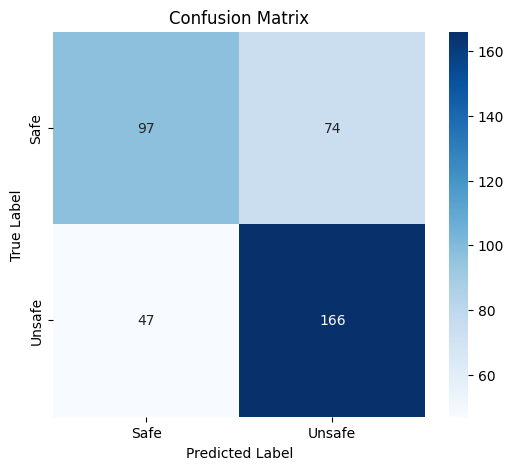

In [45]:
class_names = ['Safe', 'Unsafe']  
plot_confusion_matrix(all_labels, all_preds, class_names)